<a href="https://colab.research.google.com/github/mihnin/mihnin/blob/master/AutoML_SberBank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание проекта
В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах. Нужно научиться определять рыночную стоимость объектов недвижимости с применением машинного обучения.
Auto ML


## Загрузим библиотеку AutoML

In [ ]:
!pip install -U lightautoml



## Step 1. Import all libs

In [ ]:
%matplotlib inline

import warnings  # Применяю библиотеку варнингс для сокрытия предупреждений.
warnings.filterwarnings("ignore")

# Standard python libraries
import os
import time
import re

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task


from pathlib import Path
# в переменную записываем путь к файлу с которым будем работать
file = Path.cwd() / 'data' / 'raw' / 'train_data.csv'
#data = pd.read_csv('c:/Temp/train_data.csv') #Загружаем данные из csv в переменную data
data = pd.read_csv(file)

In [ ]:
data.head()

,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest
0,5400000.0,59.0,2,2.87,4.0,31.5,2,0.0,0.0,0.0,6.6,0.0,20485.0,8180.0
1,13200000.0,109.0,4,3.15,5.0,72.0,2,0.0,0.0,0.0,12.2,0.0,42683.0,8643.0
2,7000000.0,74.5,3,2.58,10.0,49.0,9,0.0,0.0,0.0,10.8,0.0,14078.0,16670.0
3,3200000.0,37.4,1,2.50,9.0,20.0,4,0.0,0.0,0.0,6.2,2.0,17792.0,17699.0
4,6650000.0,64.9,3,2.65,12.0,41.9,11,0.0,0.0,0.0,10.4,0.0,14767.0,10573.0


## Step 2. Define Parameters

In [ ]:
N_THREADS = 4 # threads number for lightgbm and linear models
N_FOLDS = 5 # folds number for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 3600 # Time in seconds for automl run
TARGET_NAME = 'last_price' # Name for target column 

## Step 3. Fix torch number of threads and numpy seed

In [ ]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

## Step 4. Data load

In [ ]:
%%time
train_data = data.loc[1201: 6494, :]
train_data.head()

Wall time: 1e+03 µs


,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest
1201,3730000.0,36.2,1,2.60,12.0,21.4,12,0.0,0.0,0.0,7.3,0.0,43692.0,10473.0
1202,10950000.0,101.3,3,3.15,5.0,61.6,5,0.0,0.0,0.0,34.7,0.0,16431.0,6511.0
1203,36800000.0,152.2,3,3.30,5.0,53.9,5,0.0,0.0,0.0,43.4,1.0,36779.0,14931.0
1204,4800000.0,35.7,1,2.70,19.0,15.1,8,0.0,0.0,0.0,9.3,0.0,16501.0,10163.0
1205,3699000.0,45.0,2,2.55,9.0,23.9,3,0.0,0.0,0.0,6.0,2.0,14852.0,16447.0


In [ ]:
features = data.loc[0: 1200, :]
test_data = features.drop(['last_price'], axis=1)  # извлекаем целевой признак в целевую переменную
test_data.head()

,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest
0,59.0,2,2.87,4.0,31.5,2,0.0,0.0,0.0,6.6,0.0,20485.0,8180.0
1,109.0,4,3.15,5.0,72.0,2,0.0,0.0,0.0,12.2,0.0,42683.0,8643.0
2,74.5,3,2.58,10.0,49.0,9,0.0,0.0,0.0,10.8,0.0,14078.0,16670.0
3,37.4,1,2.50,9.0,20.0,4,0.0,0.0,0.0,6.2,2.0,17792.0,17699.0
4,64.9,3,2.65,12.0,41.9,11,0.0,0.0,0.0,10.4,0.0,14767.0,10573.0


In [ ]:
target = data.loc[0: 1200, :]
submission = target['last_price']  # создаем перменную target из значений целевого признаков
submission.head()

0     5400000.0
1    13200000.0
2     7000000.0
3     3200000.0
4     6650000.0
Name: last_price, dtype: float64

In [ ]:
train_data.shape, test_data.shape

((5294, 14), (1201, 13))

In [ ]:
train_data[TARGET_NAME].describe()

count    5.294000e+03
mean     8.053649e+06
std      1.191627e+07
min      1.219000e+04
25%      4.320000e+06
50%      5.650000e+06
75%      8.260000e+06
max      4.200000e+08
Name: last_price, dtype: float64

<AxesSubplot:>

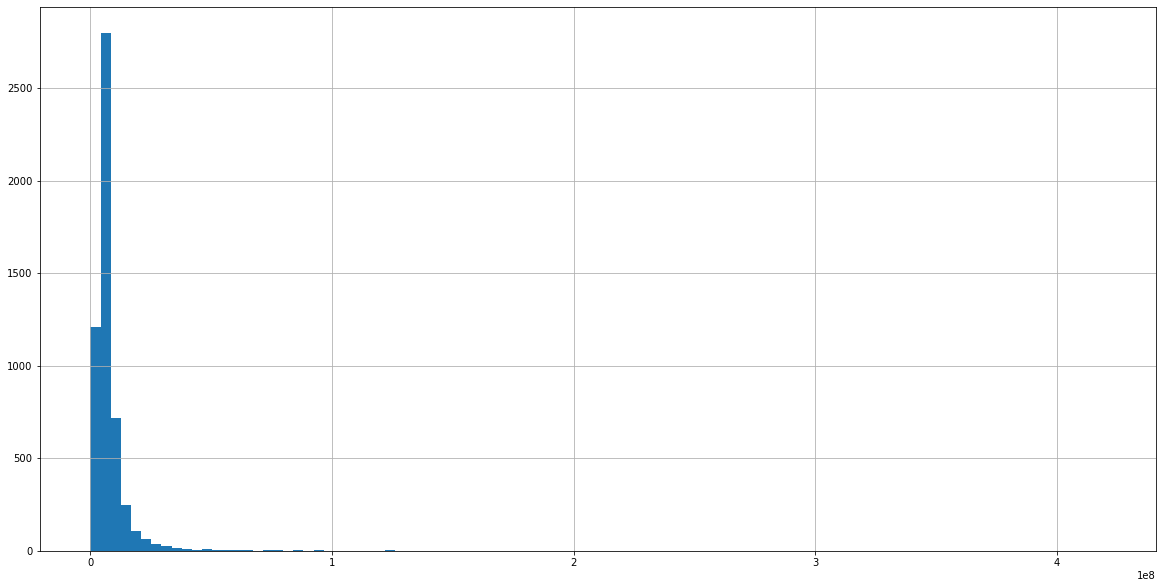

In [ ]:
train_data[TARGET_NAME].hist(bins = 100  , figsize = (20, 10))

<AxesSubplot:>

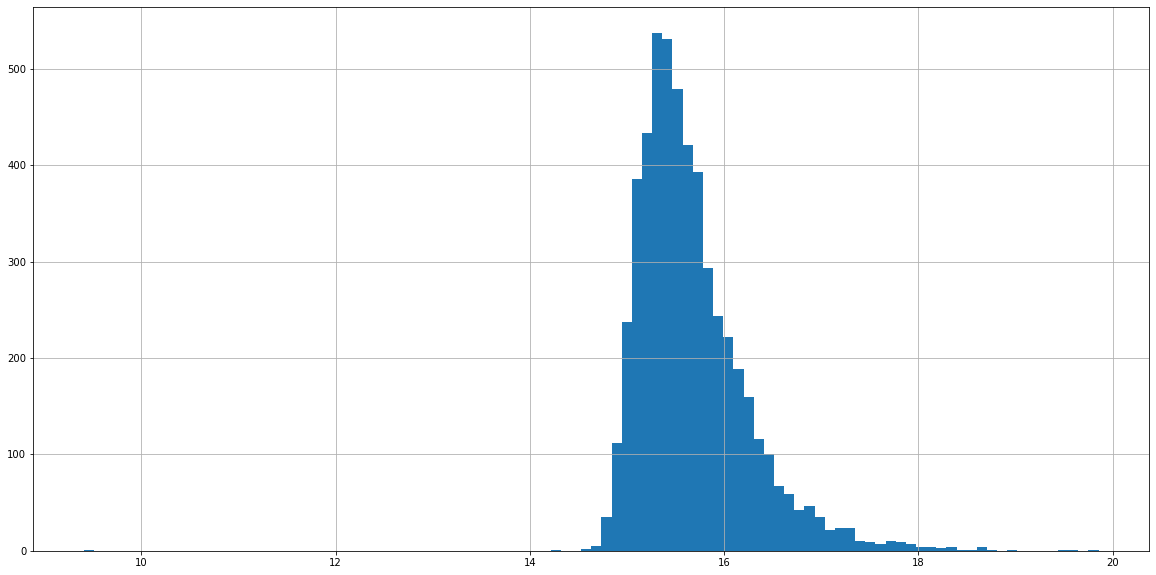

In [ ]:
np.log(train_data[TARGET_NAME] + 1).hist(bins = 100, figsize = (20, 10))

## Step 5. Add new features

In [ ]:
def create_extra_features(dt):
    dt['FloorDiff'] = dt['floors_total'] - dt['floor']
    dt['MeanRoomSize'] = dt['living_area'] / dt['rooms']

#def create_gr_feats(data):
#    for col in ['Walls', 'District', 'Okrug']:
#        for n, f in [('mean', np.mean), ('min', np.nanmin), ('max', np.nanmax)]:
#            data[n + '_size_by_' + col] = data.groupby(col)['Size'].transform(f)
#    for col in ['Size', 'Room', 'Balcony', 'Floor', 'FloorsTotal',
#               'Walls','Age','Lift', 'District', 'Okrug']:
#        data[col + '_cnt'] = data[col].map(data[col].value_counts(dropna = False))

create_extra_features(train_data)
create_extra_features(test_data)

all_df = pd.concat([train_data, test_data]).reset_index(drop = True)

#create_gr_feats(all_df)
train_data, test_data = all_df[:len(train_data)], all_df[len(train_data):]
print(train_data.shape, test_data.shape)

(5294, 16) (1201, 16)


In [ ]:
train_data

,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,FloorDiff,MeanRoomSize
0,3730000.0,36.2,1,2.60,12.0,21.4,12,0.0,0.0,0.0,7.3,0.0,43692.0,10473.0,0.0,21.400000
1,10950000.0,101.3,3,3.15,5.0,61.6,5,0.0,0.0,0.0,34.7,0.0,16431.0,6511.0,0.0,20.533333
2,36800000.0,152.2,3,3.30,5.0,53.9,5,0.0,0.0,0.0,43.4,1.0,36779.0,14931.0,0.0,17.966667
3,4800000.0,35.7,1,2.70,19.0,15.1,8,0.0,0.0,0.0,9.3,0.0,16501.0,10163.0,11.0,15.100000
4,3699000.0,45.0,2,2.55,9.0,23.9,3,0.0,0.0,0.0,6.0,2.0,14852.0,16447.0,6.0,11.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5289,5000000.0,40.1,1,2.65,10.0,20.1,6,0.0,0.0,0.0,10.8,1.0,26495.0,14198.0,4.0,20.100000
5290,15350000.0,158.5,7,2.95,7.0,57.4,7,0.0,0.0,0.0,12.4,1.0,23546.0,3088.0,0.0,8.200000
5291,6850000.0,62.1,2,2.75,20.0,31.0,6,0.0,0.0,0.0,13.9,2.0,34506.0,14375.0,14.0,15.500000
5292,5650000.0,66.0,3,2.50,12.0,42.2,6,0.0,0.0,0.0,10.5,0.0,12892.0,11225.0,6.0,14.066667


## ========= AutoML preset usage =========

## Step 1. Create Task

In [ ]:
%%time

task = Task('reg', loss = 'rmsle', metric = 'rmsle')

Wall time: 999 µs


## Step 2. Setup columns roles

In [ ]:
%%time

roles = {
    'target': TARGET_NAME,
    'drop': ['Id'],
}

Wall time: 0 ns


Let's set the powerful preset for tabular AutoML with iterations and informative training log

In [ ]:
%%time

cnt_trained = 0
results = []
rs_list = list(range(2000, 2007))
for it, rs in enumerate(rs_list):
    print('=' * 30)
    print('START RANDOM_STATE = {}'.format(rs))
    print('=' * 30)
    
    # Train AutoML
    automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': rs})
    oof_pred = automl.fit_predict(train_data, roles = roles)
    
    # Predict on test
    test_pred = automl.predict(test_data)
    cnt_trained += 1
    
    # Save predictions
    if it == 0:
        oof_pred_full = oof_pred.data[:, 0].copy()
        test_pred_full = test_pred.data[:, 0].copy()
    else:
        oof_pred_full += oof_pred.data[:, 0]
        test_pred_full += test_pred.data[:, 0]
    
    # Check scores for current predict and aggregated one
    rmsle_usual = mean_squared_log_error(train_data[TARGET_NAME].values, oof_pred.data[:, 0]) ** 0.5
    rmsle_full = mean_squared_log_error(train_data[TARGET_NAME].values, oof_pred_full / cnt_trained) ** 0.5
    results.append((rmsle_usual, rmsle_full, rmsle_full - rmsle_usual))
    
    print('Check scores...')
    print('Holdout score: {}'.format(rmsle_usual))
    print('Holdout score full: {}'.format(rmsle_full))
    print('Difference: {}'.format(rmsle_full - rmsle_usual))

START RANDOM_STATE = 2000
Check scores...
Holdout score: 0.22604906086026252
Holdout score full: 0.22604906086026252
Difference: 0.0
START RANDOM_STATE = 2001
Check scores...
Holdout score: 0.2279356038860417
Holdout score full: 0.22514971139813286
Difference: -0.0027858924879088365
START RANDOM_STATE = 2002
Check scores...
Holdout score: 0.22840156481172244
Holdout score full: 0.2251248372685865
Difference: -0.003276727543135932
START RANDOM_STATE = 2003
Check scores...
Holdout score: 0.22818520668706227
Holdout score full: 0.22507709912483723
Difference: -0.003108107562225043
START RANDOM_STATE = 2004
Check scores...
Holdout score: 0.22713952301771656
Holdout score full: 0.22490318523506125
Difference: -0.0022363377826553066
START RANDOM_STATE = 2005
Check scores...
Holdout score: 0.22583850242656492
Holdout score full: 0.2244764160523174
Difference: -0.0013620863742475064
START RANDOM_STATE = 2006
Check scores...
Holdout score: 0.22650486183163868
Holdout score full: 0.2242643961018

Let's make the submission file

In [ ]:
test_pred_full_0 = test_pred_full.copy() / cnt_trained

In [ ]:
import joblib
joblib.dump(test_pred_full_0, 'saved_preds.pkl')

['saved_preds.pkl']

In [ ]:
submission[TARGET_NAME] = test_pred_full_0
submission.to_csv('LightAutoML_multistart_before_pseudo_v.0.2.11.csv', index = False)

In [ ]:
submission.describe()

count        1202.0
unique        435.0
top       4500000.0
freq           18.0
Name: last_price, dtype: float64

LightAutoML can show feature importance

Wall time: 41 ms


<AxesSubplot:xlabel='Feature'>

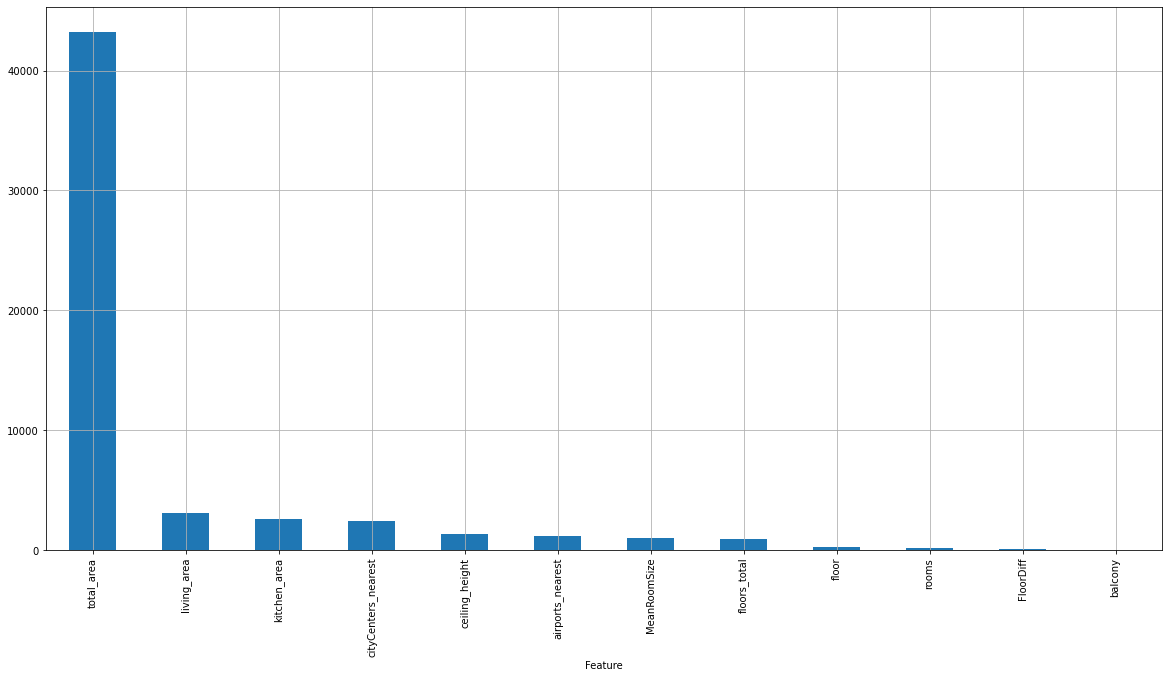

In [ ]:
%%time

# Fast feature importances calculation - logged for better visual (size is dominated in normal scale)
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

## Step 4. Graphical check

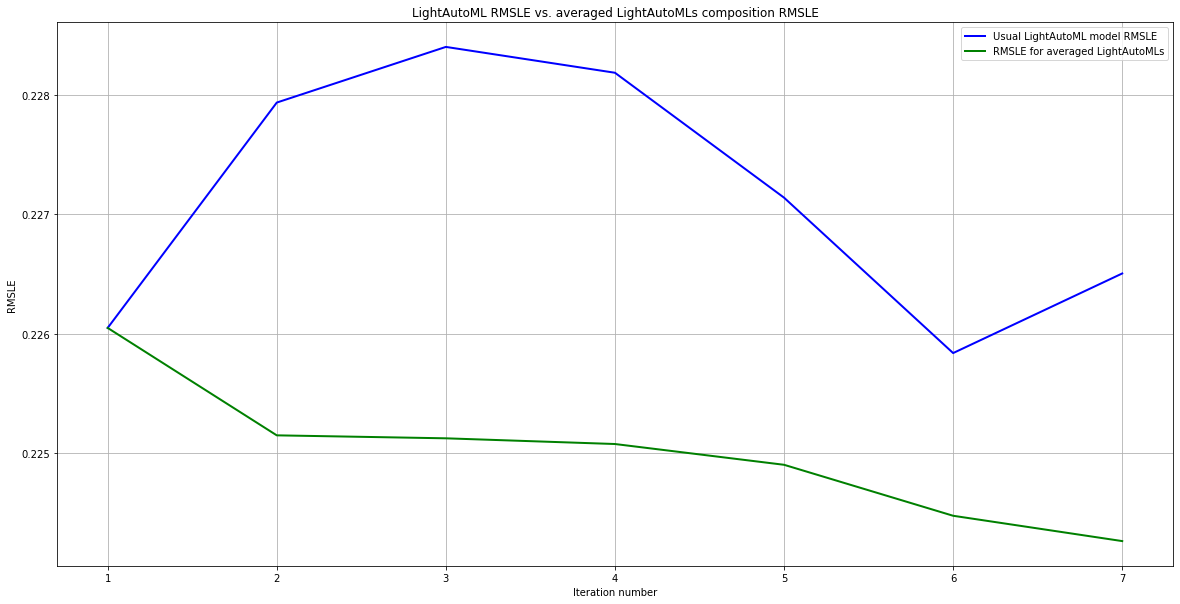

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(range(1, cnt_trained + 1), [res[0] for res in results], color = 'b', linewidth = 2, label = 'Usual LightAutoML model RMSLE')
plt.plot(range(1, cnt_trained + 1), [res[1] for res in results], color = 'g', linewidth = 2, label = 'RMSLE for averaged LightAutoMLs')
plt.grid()
plt.legend()
plt.title('LightAutoML RMSLE vs. averaged LightAutoMLs composition RMSLE')
plt.xlabel('Iteration number')
plt.ylabel('RMSLE')
plt.show()

In [ ]:
mean_rmsle = np.mean([res[0] for res in results])
mean_rmsle

0.22715061764585845

In [ ]:
differences = np.array([res[1] - mean_rmsle for res in results])

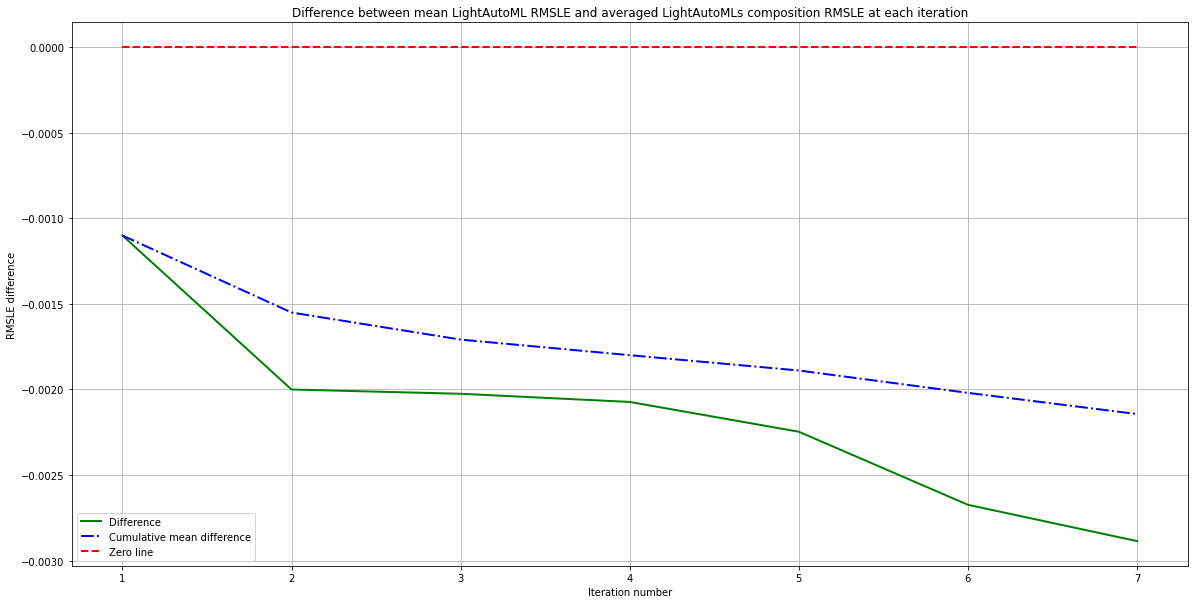

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(range(1, cnt_trained + 1), differences, color = 'g', linewidth = 2, label = 'Difference')
plt.plot(range(1, cnt_trained + 1), [np.mean(differences[0:i+1]) for i in range(len(differences))], 'b-.', linewidth = 2, label = 'Cumulative mean difference')
plt.plot(range(1, cnt_trained + 1), [0.0 for res in results], 'r--', linewidth = 2, label = 'Zero line')
plt.grid()
plt.legend()
plt.title('Difference between mean LightAutoML RMSLE and averaged LightAutoMLs composition RMSLE at each iteration')
plt.xlabel('Iteration number')
plt.ylabel('RMSLE difference')
plt.show()

## Test

In [ ]:
def create_extra_features(dt):
    dt['FloorDiff'] = dt['floors_total'] - dt['floor']
    dt['MeanRoomSize'] = dt['living_area'] / dt['rooms']

create_extra_features(data)
data.head(2) # Посмотрим стоимость 2-х квартир и проверим как наша новая модель предскажет конечную стоимость и какова будет погрешность

,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,FloorDiff,MeanRoomSize
0,5400000.0,59.0,2,2.87,4.0,31.5,2,0.0,0.0,0.0,6.6,0.0,20485.0,8180.0,2.0,15.75
1,13200000.0,109.0,4,3.15,5.0,72.0,2,0.0,0.0,0.0,12.2,0.0,42683.0,8643.0,3.0,18.00


In [ ]:
new_features3 = pd.DataFrame(
    [['NaN', 59.0, 2, 2.87, 4.0, 31.5, 2, 0.0, 0.0, 0.0, 6.6, 0.0, 20485.0, 8180.0, 2.0, 15.75],
     ['NaN', 109.0, 4, 3.15, 5.0, 72.0, 2, 0.0, 0.0, 0.0, 12.2, 0.0, 42683.0, 8643.0, 3.0, 18.00 ]],
    columns=data.columns)  #Создаем для теста датафрейм 

In [ ]:
# Проверяем что предскажет наша модель
new_features33 = new_features3

result_my_model = automl.predict(new_features33)

display('Результаты AutoML', result_my_model)


'Результаты AutoML'

array([[ 5576424.],
       [10933290.]], dtype=float32)

## Итого: модель AutoML предсказала мне стоимость 5576424 , которая отличается от первоначальной 5400000
в части второй квартиры, все очень плохо 13200000. против 10933290